In [ ]:
# default_exp core

# Module core

> Nipype and mrtrix3 based pre-/post- processing pipeline for brain diffusion-MRI and generation of structural connectomes of the brain. This module contains customized and up-to-date command line interfaces that are not found from Nipype's interfaces module.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
%%capture
#export
import os, sys
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, File
from nipype.interfaces.base import TraitedSpec, traits
from nipype.interfaces.io import DataSink, BIDSDataGrabber
from bids.layout import BIDSLayout

Environment testing:

In [ ]:
#test if our sample data can create BIDS layouts
data_dir = 'data'

## test datasets first:
data1 = os.path.join(data_dir)
#data2 = os.path.join(data_dir, 'healthy_control/')

layout = BIDSLayout(data1)
assert len(layout.get_subjects()) != 0
assert type(layout.get_subjects() is list)

#layout = BIDSLayout(data2)
#assert len(layout.get_subjects()) != 0
#assert type(layout.get_subjects() is list)

In [ ]:
#test if FSL is set up properly
assert "FSLOUTPUTTYPE" in os.environ
assert "FSLDIR" in os.environ
if "FSLOUTPUTTYPE" in os.environ:
    pass
else:
    sys.exit('FSLOUTPUTTYPE is not defined, make sure FSL is configured!')

if "FSLDIR" in os.environ:
    pass
else:
    sys.exit('FSLOUTPUTTYPE is not defined, make sure FSL is configured!')

### BIDS Data Input

Get subjects from BIDS directory:

In [ ]:
#export
def get_subs(sub_dir = 'data'):
    """
    Gets list of subjects in a BIDS directory, by default it looks in "data" folder in your CWD
    Input str of path to BIDS dir otherwise
    """
    print('Creating layout of data directory, might take a while if there are a lot of subjects')
    layout = BIDSLayout(sub_dir)
    sub_list = layout.get_subjects()
    return sub_list, layout

In [ ]:
#example usage:
sub_list, layout = get_subs(data_dir)
print(sub_list)

Creating layout of data directory, might take a while if there are a lot of subjects
['11048']


In [ ]:
#test if subjects were all grabbed
assert len(get_subs(data_dir)[0]) == len(next(os.walk(data_dir))[1])

Creating layout of data directory, might take a while if there are a lot of subjects


Find FSL `.bval/.bvec` gradient file paths:

In [ ]:
#export
def get_bfiles(BIDS_layout):
    """
    read .bvec and .bval files in as a list and spit out tuple for nipype input
    """
    bvs = layout.get(subject = sub_list[0], suffix = 'dwi', session = 1, extensions = ['bvec', 'bval'], return_type = 'file')
    bvs_tuple = tuple(bvs)[::-1]
    return bvs_tuple

In [ ]:
#example usage:
bfiles_fsl = get_bfiles(layout)
print(bfiles_fsl)

('/Users/xxie/lab/pipetography/data/sub-11048/ses-1/dwi/sub-11048_ses-1_dwi.bvec', '/Users/xxie/lab/pipetography/data/sub-11048/ses-1/dwi/sub-11048_ses-1_dwi.bval')


In [ ]:
#test if bfiles are grabbed
assert len(bfiles2tuple(layout)) == 2

Get dwi images:

In [ ]:
#example usage
dwi = layout.get(subject = sub_list[0], suffix = 'dwi', extensions = ['.nii', '.nii.gz'], return_type = 'file')

In [ ]:
#test if all sessions are grabbed
assert len(dwi) == len(layout.get_sessions())

Denoise DWI

In [ ]:
#export
class dwidenoiseInputSpec(CommandLineInputSpec):
    """
    Specifying inputs to dwidenoise
    """
    in_file = File(exists=True, mandatory=True, argstr = '%s', position = 1, desc = 'input image')
    noise = File(mandatory=True, argstr = '-noise %s', position = 2, desc = 'output noise map')
    out_file = File(mandatory = True, argstr = '%s', position = -1, desc = 'output denoised image')
    quiet = traits.Str(argstr = '%s', position = 3, desc = 'suppress verbose outputs')
    force = traits.Str(argstr = '%s', position = 4, desc = 'force output file if the file already exits')
    nthreads = traits.Int(argstr = '-nthreads %d', position = 5, desc = 'use this number of threads')

class dwidenoiseOutputSpec(TraitedSpec):
    """
    Specifying outputs of dwidenoise
    """
    noise = File(argstr = '%s', desc = 'output noise level map')
    out_file = File(argstr = '%s', desc = 'output denoised file')
    
class dwidenoise(CommandLine):
    """
    Denoise DWI data with mrtrix3's dwidenoise.
    This should be performed as the first step of the preprocessing pipeline!
    Arguments:
        in_file (str): Input DWI image
        noise (str): output noise map
        out_file (str): output denoised image
        quiet (str): whether we should suppress output
        force (str): replace existing image (overwrite past runs outputs)
        nthreads (int): number of threads to use
    """
    _cmd = 'dwidenoise'
    input_spec = dwidenoiseInputSpec
    output_spec = dwidenoiseOutputSpec
    
    def _list_outputs(self):
        outputs = self.output_spec().get()
        outputs['noise'] = os.path.abspath(self.inputs.noise)
        outputs['out_file'] = os.path.abspath(self.inputs.out_file)
        return outputs

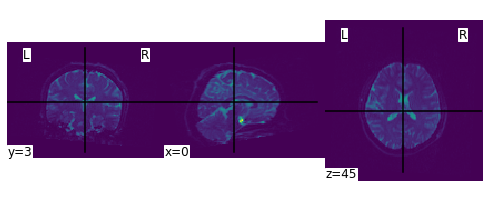

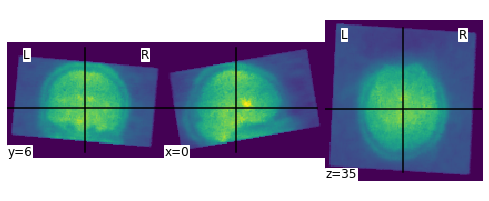

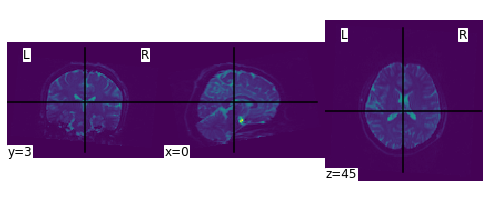

In [ ]:
#example usage:
import nibabel as nb
from nilearn import plotting
from nilearn.image import new_img_like

denoise = dwidenoise()
denoise.inputs.out_file = 'outputs/denoised.nii.gz'
denoise.inputs.noise = 'outputs/noise.nii.gz'
denoise.inputs.in_file = dwi[0] # the first session's image
denoise.inputs.force = '-force'
denoise.run();

orig_dwi = nb.load(dwi[0]) # display dwi
orig_data = orig_dwi.get_fdata()[:,:,:,0]
orig_img = new_img_like(orig_dwi, orig_data, affine = orig_dwi.affine, copy_header = True)
_ = plotting.plot_img(orig_img)

_ = plotting.plot_img(denoise.inputs.noise)

denoised_dwi = nb.load(denoise.inputs.out_file)
denoised_data = denoised_dwi.get_fdata()[:,:,:,0]
denoised_img = new_img_like(denoised_dwi, denoised_data, affine = denoised_dwi.affine, copy_header = True)
_ = plotting.plot_img(denoised_img)

In [ ]:
#test if denoised file exists
from fastcore.test import *

test_eq(os.path.exists(denoise.inputs.noise), True)
test_eq(os.path.exists(denoise.inputs.out_file), True)

Bias field correction:

In [ ]:
#export
class N4BiasFieldCorrectionInputSpec(CommandLineInputSpec):
    """
    Input specifications
    """
    in_file = File(exists=True, mandatory=True, argstr='-i %s',
                  position = 1, desc = 'input denoised file')
    dims = traits.Int(mandatory = True, argstr = '-d %d',
                     position = 0, desc = 'dimension of input image')
    out_file = File(mandatory=True, argstr='-o %s', position = 2,
                         desc = 'the output image')

class N4BiasFieldCorrectionOutputSpec(TraitedSpec):
    """
    Output specifications
    """
    out_file = File(desc = 'output denoised and bias corrected file')

class N4BiasFieldCorrection(CommandLine):
    """
    ANTs Bias field correction.
    Arguments:
        in_file (str) = input file, for the pipeline, connect the denoised dwi file here
        dims (int)    = input volume dimensions, for dwi's the value is 4
        outfile (str) = name of output file, for pipeline, connect this to datasink and next step
    Returns:
        out_file (str) = .nii.gz file output, bias field corrected image
    """
    _cmd = 'N4BiasFieldCorrection'
    input_spec = N4BiasFieldCorrectionInputSpec
    output_spec = N4BiasFieldCorrectionOutputSpec

    def _list_outputs(self):
        outputs = self.output_spec().get()
        outputs['out_file'] = os.path.abspath(self.inputs.out_file)
        # Get the attribute saved during _run_interface
        return outputs

In [ ]:
#example usage
ants_bfc = N4BiasFieldCorrection()
ants_bfc.inputs.out_file = 'outputs/biasfieldcorrected.nii.gz'
ants_bfc.inputs.dims = 4
ants_bfc.inputs.in_file = 'outputs/denoised.nii.gz'
ants_bfc.run()

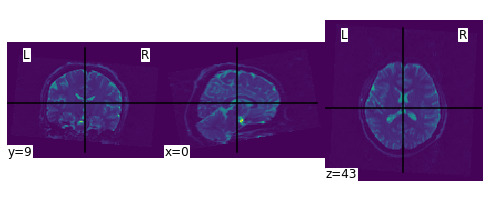

In [ ]:
## visualize
corrected_dwi = nb.load(ants_bfc.inputs.out_file)
corrected_data = corrected_dwi.get_fdata()[:,:,:,0] #first b0 volume
correctedb0_img = new_img_like(corrected_dwi, corrected_data, affine = corrected_dwi.affine, copy_header = True)
_ = plotting.plot_img(correctedb0_img)

In [ ]:
#test if file output is correct
test_eq(os.path.exists(ants_bfc.inputs.out_file), True)

Motion and eddy current correction

In [ ]:
#export
class dwipreprocInputSpec(CommandLineInputSpec):
    in_file = File(exists=True, mandatory = True, argstr='%s',
                  position = 0, desc = 'input denoised, corrected file')
    rpe_options = traits.Str(mandatory = True, argstr = '%s', position = 2,
                            desc = 'acquisition phase-encoding design')
    pe_dir = traits.Str(mandatory = True, argstr = '-pe_dir %s', position = 3,
                       desc = 'phase encoding direction')
    eddy_options = traits.Str(mandatory = False, argstr = '-eddy_options %s', position = 4,
                             desc = 'eddy command options within quotation marks and contains at least one space')
    nthreads = traits.Int(mandatory = False, argstr = '-nthreads %d', position = 5,
                            desc = 'number of available CPUs to use, no input means all available CPUs')
    grad_fsl = traits.Tuple((traits.Str, traits.Str), mandatory=True, argstr = '-fslgrad %s %s',
                           position = 6, desc = 'provide gradient table in fsl format')
    out_file = File(mandatory = True, argstr='%s', position = 1,
                       desc = 'output denoised, corrected, preproc image')

class dwipreprocOutputSpec(TraitedSpec):
    out_file = File(argstr='%s', desc = 'output denoised, corrected, preproc image')

class dwipreproc(CommandLine):
    """
    mrtrix3 dwipreproc for motion/eddy current correction
    Arguments: 
        in_file (str): input file that needs the artifact correction
        rpe_options (str): phase-encoding design, see mrtrix3's dwipreproc for detail options
        pe_dir (str): phase encoding directions, see mrtrix3's dwipreproc for detail options
        eddy_options (str): eddy current correction options. see mrtrix3's dwipreproc for detail options
        nthreads (int): number of threads used
        grad_fsl (tuple): bvec/bval files
        out_file (str): file name and path for output
    Returns:
        out_file (str): preprocessed file, this is the input to tractography.
    """
    _cmd = 'dwipreproc'
    input_spec = dwipreprocInputSpec
    output_spec = dwipreprocOutputSpec

    def _list_outputs(self):
        outputs = self.output_spec().get()
        outputs['out_file']=os.path.abspath(self.inputs.out_file)
        return outputs

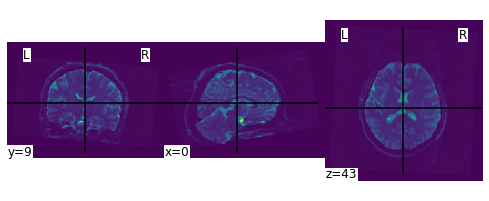

In [ ]:
#example usage:
preproc = dwipreproc()
preproc.inputs.in_file = ants_bfc.inputs.out_file
preproc.inputs.rpe_options = '-rpe_none'
preproc.inputs.pe_dir = 'j-' #AP direction
preproc.inputs.eddy_options = '"--slm=linear "'
preproc.inputs.nthreads = 4
preproc.inputs.grad_fsl = bfiles_fsl
preproc.inputs.out_file = 'outputs/preproc.nii.gz'
preproc.run()

## visualize
preproc_dwi = nb.load(preproc.inputs.out_file)
preproc_data = preproc_dwi.get_fdata()[:,:,:,0] #first b0 volume
preproc_img = new_img_like(preproc_dwi, preproc_data, affine = preproc_dwi.affine, copy_header = True)
_ = plotting.plot_img(preproc_img)

In [ ]:
# test if image has been produced
test_eq(os.path.exists(preproc.inputs.out_file), True)

Brain extraction function input format:

In [ ]:
#export
def mask2seedtuple(mask_file, grid_size):
    seed_grid_tuple = (mask_file, grid_size,)
    return seed_grid_tuple